3. Com base no notebook estudado mnist_sgd disponível em: https://github.com/josenalde/machinelearning/blob/main/src/mnist_sgd.ipynb, escreva uma função que possa mover uma imagem do MNIST em qualquer direça o (left, right, up, down) em X pixels. Pode começar testando X=1 e as adicione ao conjunto de treinamento. Faça a classificação multiclasse com o SGD e veja se os resultados melhoraram em termos de confusão com os números. Para esta função, considere usar o método shift() do módulo scipy.ndimage.interpolation. Por exemplo shift(image, [2,1], cval=0) desloca a imagem dois pixels para baixo e um pixel a direita.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.ndimage import shift

In [2]:
# Carrega MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
# Divide em treino/teste
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

Definir Função de Deslocamento Parametrizada

In [3]:
def move_image(image, direction, X=2):
    # direction: 'up', 'down', 'left', 'right'
    mapping = {
        'up':    ( -X,  0),
        'down':  (  X,  0),
        'left':  (  0, -X),
        'right': (  0,  X)
    }
    dx, dy = mapping[direction]
    # image vem em shape (784,) -> reshape, shift, reshape
    img = image.reshape(28, 28)
    shifted = shift(img, [dx, dy], cval=0)
    return shifted.reshape(-1)

Visualizando imagens antes e após deslocamento

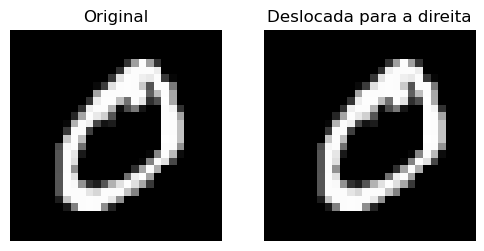

In [4]:
index = 1  # pode variar o índice
original = X_train[index].reshape(28,28)
shifted = move_image(X_train[index], 'right', X=1).reshape(28,28)

fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(shifted, cmap='gray')
axes[1].set_title('Deslocada para a direita')
for ax in axes:
    ax.axis('off')
plt.show()

Aumentação do Conjunto de Treinamento

In [5]:
# Gera versões deslocadas de cada imagem em 4 direções
directions = ['up', 'down', 'left', 'right']
augmented_images = []
augmented_labels = []
for img, label in zip(X_train, y_train):
    for d in directions:
        augmented_images.append(move_image(img, d, X=1))
        augmented_labels.append(label)
# Concatena
X_train_aug = np.vstack([X_train] + augmented_images)
y_train_aug = np.hstack([y_train] + augmented_labels)
print(f"Tamanho original: {len(X_train)}; após augmentação: {len(X_train_aug)}")

Tamanho original: 60000; após augmentação: 300000


Pipeline com StandardScaler e SGDClassifier com Early Stopping

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('sgd', SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        random_state=42
    ))
])

Treino e Avaliação Sem Augmentação

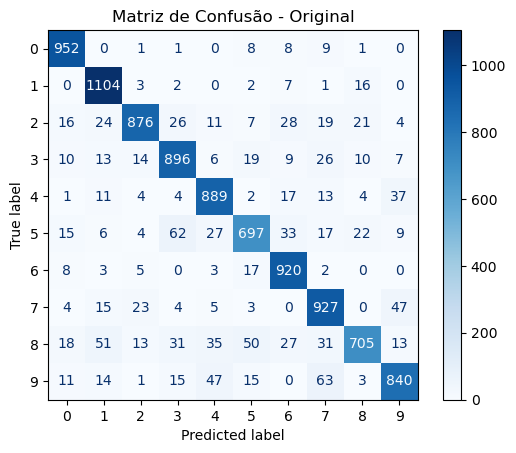

In [7]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm_original = confusion_matrix(y_test, y_pred)
disp_orig = ConfusionMatrixDisplay(cm_original)
disp_orig.plot(cmap='Blues')
plt.title('Matriz de Confusão - Original');
plt.show()

Treino e Avaliação Com Augmentação

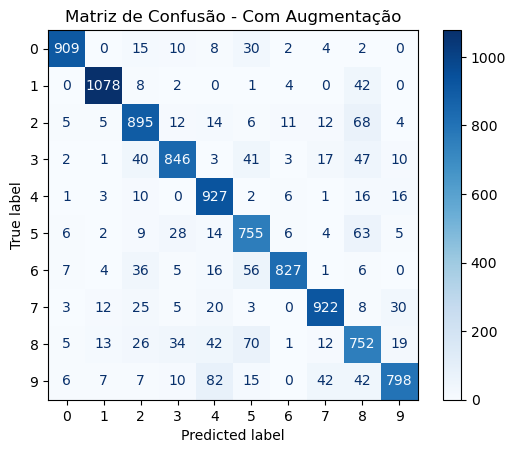

In [8]:
pipeline.fit(X_train_aug, y_train_aug)
y_pred_aug = pipeline.predict(X_test)
cm_aug = confusion_matrix(y_test, y_pred_aug)
disp_aug = ConfusionMatrixDisplay(cm_aug)
disp_aug.plot(cmap='Blues')
plt.title('Matriz de Confusão - Com Augmentação');
plt.show()